<a href="https://colab.research.google.com/github/mtxslv/digitalprocessingsimulations/blob/master/FFTconvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolução no domínio da frequência
Devem ser implementados algoritmos que consigam realizar convoluções via métodos:
>Sobreposição-e-soma;
>Sobreposição_e_armazenamentto







Suponha uma sequência x_n longa, com U elementos e uma sequência h_n com M elementos. Suponha, por fim, que seja possível realizar uma FFT com N = 512 pontos.

PARA FUNCIONAR, PRECISA-SE DEFINIR M E N PREVIAMENTE.

In [35]:
N = 512 #We'll apply a 512-points FFT. It is the amount of elements each sequence should have
M = 124 #M is the amount of samples in h_n. 
L = N-M+1 #We should set a L value. It is the amount of elements each block shall have. Note that, with M and N given, L is defined.
print(L)

389


##Importando códigos

In [0]:
# Important Imports
import numpy as np #using numpy arrays
import math # ceil method
import matplotlib.pyplot as plt # plotting loops

## Definição da convolução circular

O código ```cconvolve()``` recebe duas sequências unidimensionais de mesmo comprimento e devolve a convolução circular entre as duas. O resultado possui o mesmo número de pontos que quaisquer uma das duas recebidas.



In [0]:
def cconvolve(x,h):
  '''
  input: numpy-like sequences to be circular convolved (x[n] and y[n])
  output: circular convolution of x[n] and h[n] (y[n]: numpy-like sequence).
  '''
  h_matrix = np.zeros((h.shape[0],h.shape[0])) #h_matrix has dimention (dimension_of_h,dimension_of_h)
  
  # making h_matrix:
  for i in range(0,h.shape[0]):
    h_matrix[:,i] = np.roll(h,i) #each column of h_matrix is h.T rolled by column_numbers unities.
 
  #circular convolving x[n] and h[n]
  y = np.dot(h_matrix,x) # y[n] = x[n](*)h[n]
  
  return y 
  

##Sobreposição e Soma

Aqui iniciaremos o código de sobreposição e soma. Para mais informações, acessar [esse link](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method)

**Abaixo se encontra o código do método *overlapping-and-add***

In [0]:
def ola(x_n,h_n): #overlapping-and-add 
  '''
  input: two sequences (x_n and h_n)
  output: the circular convolution of x_n and h_n through overlapping-add method
  '''
  
  #Let's turn the input sequence x_n into a block of (U/L) lines and L+M-1 columns (we are doing zero padding)
  
  #Let's check out if U/L is integer. If not, let's concatenate the remaining zeros at the end of the x_n sequence.
  #WATCH OUT! In order to work properly, x_n.shape[0]>L
  if not isinstance(x_n.shape[0]/L,int):
    x_n = np.concatenate( (x_n, np.zeros( math.ceil( x_n.shape[0]/L )*L-x_n.shape[0]) ) )
  
  #xl_n will have U/L lines and L columns.
  xl_n = x_n.reshape( int(x_n.shape[0]/L) , L)

  #Concatenating M-1 null columns at the end of the matrix
  zero_column = np.zeros( (int(x_n.shape[0]/L), M-1) )
  xl = np.concatenate((xl_n,zero_column),axis = 1)
  
  #x_n is ready. Working with h_n...
  
  #h_n has M samples, then, we should zero-pad it with L-1 null samples.
  n_h_n = np.concatenate((h_n, np.zeros(L-1)))
  
  #n_h_n is ready. Now we have to find y_matrix
  
  y_matrix = np.zeros(xl.shape) # matrix with xl dimension 
  
  H_k = np.fft.fft(n_h_n) # H_k is the n_h_n FFT
  
  for i in range(xl.shape[0]): # do the loop for each line of xl
    X_k = np.fft.fft(xl[i,:]) # X_k is the FFT of the sequence stored in i line of xl
    Y_k = np.multiply(X_k,H_k.T) # Y_k is the element-wise product of X_k and H_k
    y_ = np.fft.ifft(Y_k) # y_ is the inverse of Y_k, in discrete-time domain
    y_matrix[i,:] = y_ # i line of y_matrix stores y_ 
  
  # y_matrix is ready. Now we just need to arrange it in order to have the sequence y_n
  # y_n has the length of x_n plus M-1 samples
  
  y_n = np.zeros(y_matrix.shape[0]*(y_matrix.shape[1] - (h_n.shape[0]-1)) + 2*(h_n.shape[0]-1))

  for i in range(y_matrix.shape[0]):
    inicio = i*L
    final = inicio + y_matrix.shape[1]
    y_n[inicio:final] = y_n[inicio:final]+y_matrix[i,:]
    
  return y_n

##Sobreposição e Armazenamento


**Abaixo se encontra o código do método *overlapping-and-save***

In [0]:
def ols(x_n, h_n):#overlapping-and-save 
  '''
  input: two sequences (x_n and h_n)
  output: the circular convolution of x_n and h_n through overlapping-save method
  '''
  
  # Let's register the length of the sequences
  M_ = h_n.shape[0]
  U_ = x_n.shape[0]
  
  #Let's turn the input sequence x_n into a block of (U/L) lines and L+M-1 columns (we are doing zero padding)
  
  #Let's check out if U/L is integer. If not, let's concatenate the remaining zeros at the end of the x_n sequence.
  #WATCH OUT! In order to work properly, x_n.shape[0]>L
  if not isinstance(x_n.shape[0]/L,int):
    x_n = np.concatenate( (x_n, np.zeros( math.ceil( x_n.shape[0]/L )*L-x_n.shape[0]) ) )
  
  #xl_n will have U/L lines and L columns.
  xl_n = x_n.reshape( int(x_n.shape[0]/L) , L)

  #Concatenating M-1 columns at the beginning of the matrix
  
  #making the appendix that goes in the first columns of xl
  zero_line = np.array( [np.zeros(M-1)] )
  jeta = xl_n[:xl_n.shape[0]-1,-(M-1):]
  appendix = np.concatenate((zero_line,jeta))
  
  #defining xl
  xl = np.concatenate((appendix,xl_n),axis = 1)
  
  #h_n has M samples, then, we should zero-pad it with L-1 null samples.
  n_h_n = np.concatenate((h_n, np.zeros(L-1)))
  
  #n_h_n is ready. Now we have to find y_matrix
  
  y_matrix = np.zeros(xl.shape) # matrix with xl dimension 
  
  H_k = np.fft.fft(n_h_n) # H_k is the n_h_n FFT
  
  for i in range(xl.shape[0]): # do the loop for each line of xl
    X_k = np.fft.fft(xl[i,:]) # X_k is the FFT of the sequence stored in i line of xl
    Y_k = np.multiply(X_k,H_k.T) # Y_k is the element-wise product of X_k and H_k
    y_ = np.fft.ifft(Y_k) # y_ is the inverse of Y_k, in discrete-time domain
    y_matrix[i,:] = y_ # i line of y_matrix stores y_ 

  # y_matrix is ready. Now we just need to arrange it in order to have the sequence y_n
  
  # discard first M-1 columns
  y_mat = y_matrix[:,-L:]
  #reshape in order to return an array
  y_n = y_mat.reshape(-1,1).T[0]
  
  return y_n
    
  

##Definição de sinais de teste



Seja o filtro passa-baixa h[n] dado pela relação:
                      h[n] = sin [0.325*pi*(n-62)]
                                 -----------------
                                       pi*(n-62)
com  0<=n<124                                    
                                       

In [0]:
n = np.arange(M)
h_n = np.sin( 0.325*np.pi*(n-62))*(np.pi*(n-62))


Os sinais a serem filtrados são:

In [0]:
x1_n = np.ones(3000)
x2_n = np.ones(220)

cujo domínio é:

In [0]:
n_1 = np.arange(3000)-3000/2
n_2 = np.arange(220) - 220/2

##Testes:

In [43]:
y2_ols = ols(x2_n,h_n)
y2_ola = ola(x2_n,h_n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


In [44]:
y1_ols = ols(x1_n,h_n)
y1_ola = ola(x1_n,h_n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


3112
[  88.42769956  -11.70243723 -200.19799645 ... -224.6429419   -81.22699799
  -45.29087623]


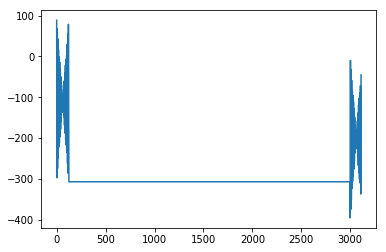

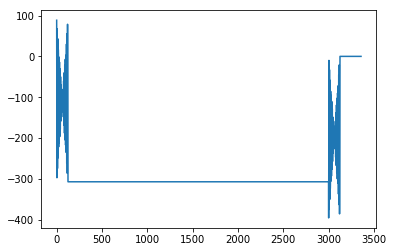

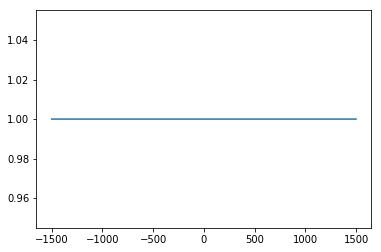

In [68]:
#comparando os resultados da primeira sequencia
print(y1_ols.shape[0])
print(y1_ols)

plt.figure(1)
plt.plot(np.arange(y1_ols.shape[0]),y1_ols)

plt.figure(2)
plt.plot(np.arange(y1_ola.shape[0]),y1_ola)

plt.figure(3)
plt.plot(n_1,x1_n)

plt.show()

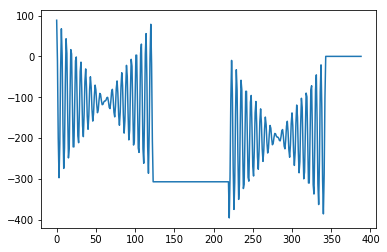

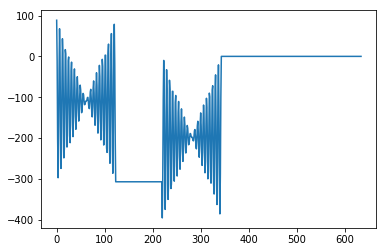

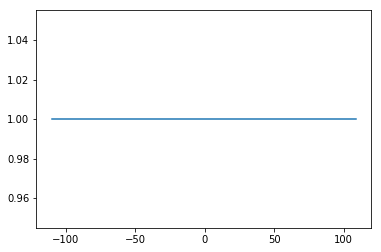

In [70]:
#comparando os resultados da segunda sequencia

plt.figure(1)
plt.plot(np.arange(y2_ols.shape[0]),y2_ols)

plt.figure(2)
plt.plot(np.arange(y2_ola.shape[0]),y2_ola)

plt.figure(3)
plt.plot(n_2,x2_n)

plt.show()